In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

from data.dataloader import Covid19IndiaLoader
from data.processing import get_data, get_district_time_series

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from utils.loss import Loss_Calculator
from main.seir.fitting import single_fitting_cycle, get_variable_param_ranges
from main.seir.forecast import get_forecast, create_region_csv, create_all_csvs, write_csv, plot_forecast

## Load Covid19india Data

In [29]:
loader = Covid19IndiaLoader()
dataframes = loader.get_covid19india_api_data()

In [30]:
predictions_dict = {}

In [9]:
df_mumbai = pd.read_csv('../../outputs/mumbai-20200516-123414.csv')
df_mumbai['predictionDate'] = pd.to_datetime(df_mumbai['predictionDate'])

In [10]:
df_mumbais = []

In [11]:
split_indices = [None] + list(df_mumbai[df_mumbai['predictionDate'] == '2020-06-22'].index) + [None]
for i in range(len(split_indices) - 1):
    if split_indices[i] != None and split_indices[i+1] != None:
        df_mumbais.append(df_mumbai.loc[split_indices[i]+1:split_indices[i+1], :].reset_index(drop=True))
    else:
        df_mumbais.append(df_mumbai.loc[split_indices[i]:split_indices[i+1], :].reset_index(drop=True))

In [12]:
df_true = predictions_dict[('Maharashtra', 'Mumbai')]['m1']['df_district']

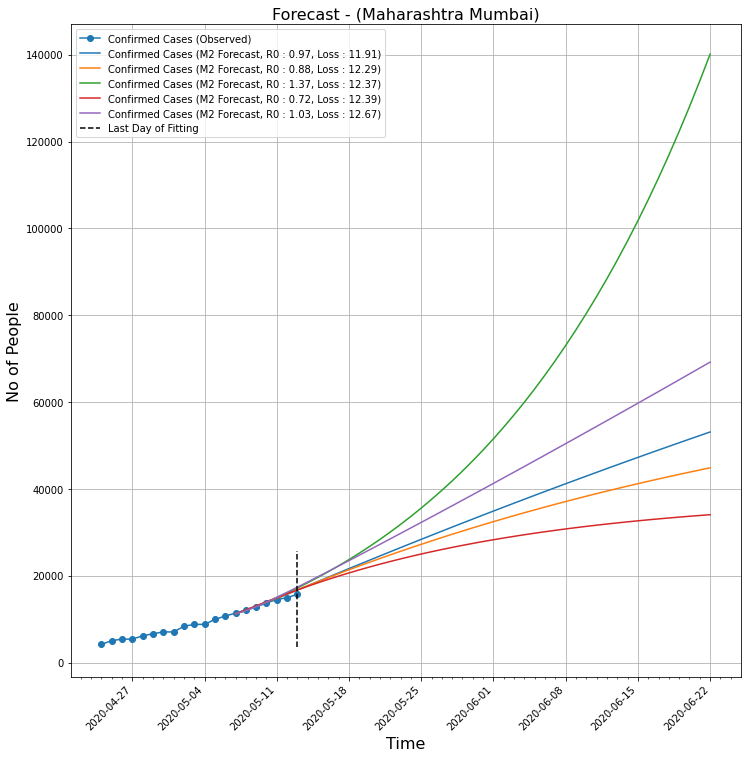

In [26]:
R0s_array = [0.97, 0.88, 1.37, 0.72, 1.03]
loss_array = [11.91, 12.29, 12.37, 12.39, 12.67]
which_compartments = ['total_infected']
fig, ax = plt.subplots(figsize=(12, 12))

if 'total_infected' in which_compartments:
    ax.plot(df_true.loc[df_true['date'] <= '2020-05-13', 'date'], df_true.loc[df_true['date'] <= '2020-05-13', 'total_infected'],
            '-o', color='C0', label='Confirmed Cases (Observed)')
if 'hospitalised' in which_compartments:
    ax.plot(df_true['date'], df_true['hospitalised'],
            '-o', color='orange', label='Active Cases (Observed)')

for i, df in enumerate(df_mumbais[0:5]):
    df = df[np.logical_not(df['total_mean'].isna())]
    if 'total_infected' in which_compartments:
        ax.plot(df['predictionDate'], df['total_mean'],
                '-', label='Confirmed Cases (M2 Forecast, R0 : {}, Loss : {})'.format(R0s_array[i], loss_array[i]))
    if 'hospitalised' in which_compartments:
        sns.lineplot(x="predictionDate", y="hospitalized_mean", data=df,
                     ls='-', label='Active Cases (M2 Forecast, R0 : {}, Loss : {}))'.format(R0s_array[i], loss_array[i]))
    if 'recovered' in which_compartments:
        ax.plot(df_true['date'], df_true['recovered'],
                '-o', color='green', label='Recovered Cases (Observed)')
        sns.lineplot(x="predictionDate", y="recovered_mean", data=df,
                     ls='-', color='green', label='Recovered Cases (M2 Forecast, R0 : {}, Loss : {}))'.format(R0s_array[i], loss_array[i]))
    if 'deceased' in which_compartments:
        ax.plot(df_true['date'], df_true['deceased'],
                '-o', color='red', label='Deceased Cases (Observed)')
        sns.lineplot(x="predictionDate", y="deceased_mean", data=df,
                     ls='-', color='red', label='Deceased Cases (M2 Forecast, R0 : {}, Loss : {}))'.format(R0s_array[i], loss_array[i]))
ax.plot([datetime.datetime.strptime('2020-05-13', '%Y-%m-%d'), datetime.datetime.strptime('2020-05-13', '%Y-%m-%d')],
        [min(df_true['hospitalised']), max(df_true['hospitalised'])], '--', color='black', label='Last Day of Fitting')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('No of People', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.xticks(rotation=45, horizontalalignment='right')
plt.legend()
plt.title('Forecast - (Maharashtra Mumbai)', fontsize=16)
plt.grid()

In [15]:
for i in range(len(df_mumbais)):
    print(i, df_mumbais[i].loc[df_mumbais[i]['predictionDate'] == '2020-05-31', 'total_mean'])

0 50    33983.0
Name: total_mean, dtype: float64
1 50    31753.0
Name: total_mean, dtype: float64
2 50    48966.0
Name: total_mean, dtype: float64
3 50    27883.0
Name: total_mean, dtype: float64
4 50    39980.0
Name: total_mean, dtype: float64


In [14]:
indexes = [1, 5, 6, 7, 9, 10]
for index in sorted(indexes, reverse=True):
    del df_mumbais[index]

## Create and Save Output CSV

In [85]:
df_output = create_all_csvs(predictions_dict, initialisation='intermediate', train_period=7, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..


In [88]:
write_csv(df_output, '../../output-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))